In [1]:
from dotenv import dotenv_values
import pathlib
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

import torch
import pytorch3d.transforms.rotation_conversions as rc

import dataset_configs.realdisp.consts as rd_consts
from wimusim import WIMUSim, Optimizer, utils

pybullet build time: Nov 28 2023 23:51:11


## Introduction
The parameter identification process in WIMUSim involves optimizing WIMUSim's parameters to closely replicate real-world IMU data. This process is crucial for ensuring that the simulated IMU data reflects the real-world sensor dynamics as accurately as possible. The main goal is to minimize the discrepancy between the real and simulated data by fine-tuning the four primary parameters in WIMUSim: Body (B), Dynamics (D), Placement (P), and Hardware (H).


### What We Will Do in This Notebook
In this notebook, we will demonstrate the parameter identification process using the **REALDISP dataset**. The workflow will be as follows:
1. **Setup the WIMUSim Environment**: Initialize the WIMUSim simulation environment using the REALDISP dataset and define initial values for the B, D, P, and H parameters.
2. **Define Optimization Configurations**: Set up the optimization objective, including loss functions and constraints.
3. **Run the Optimization**: Optimize the parameters using gradient-based methods to match the simulated IMU data with the real data.
4. **Analyze the Results**: Visualize the optimization progress and evaluate the final parameter values against the target data.

By the end of this notebook, you will see how WIMUSim can be configured and optimized for real-world datasets to achieve high-fidelity IMU simulations.


In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

Using GPU: NVIDIA GeForce GTX 1080 Ti


## Setup the WIMUSim environment

The first step is to prepare the initial WIMUSim parameters. These parameters define the initial configurations of the body structure, sensor placements, joint dynamics, and hardware characteristics. We will use the **REALDISP** dataset for this process.

### Step 1: **Specify the Dataset Path**
Make sure that the path to the REALDISP dataset is correctly specified in the `.env` file. The `.env` file should contain the following entry:

```
REALDISP_PATH=<path_to_REALDISP_dataset>
```


In [3]:
REALDISP_PATH = dotenv_values()["REALDISP_PATH"] # Path to the REALDISP dataset

# Specify the subject ID and scenario type (use "ideal" for this notebook as we use the default P values set for the ideal scenario)
subject_id = 2
scenario_type = "ideal"

filepath = pathlib.Path(
        f"{REALDISP_PATH}/subject{subject_id}_{scenario_type}.log"
    )

df_IMU = pd.read_csv(
    filepath,
    sep="\t",
    names=rd_consts.REALDISP_COLUMNS,
)

### Step 2.1: **Initialize the Dynamics (D) Parameters**
The initial **Dynamics (D)** parameters represent the movement patterns of the human joints, defined using **quaternion sequences**. We will extract these initial D parameters from the quaternion data of the IMUs in the REALDISP dataset.

The following code snippet demonstrates how to load the quaternion data from REALDISP and compute the initial D parameters:

In [4]:
def calculate_initial_D_param(
    q_IMU_dict: dict, P_ro_dict: dict, apply_savgol_filter=False
) -> dict:
    """
    Calculate the initial D parameters from the raw quaternion data.

    :param q_IMU_dict: Dictionary of the raw quaternion data from the IMUs
    :param P_ro_dict: Placement parameters
    :return: Dictionary of the initial D parameters
    """

    n_samples = list(q_IMU_dict.values())[0].shape[0]
    q_rq_dict = {
        k: rc.matrix_to_quaternion(rc.euler_angles_to_matrix(torch.tensor(v), "XYZ"))
        for k, v in P_ro_dict.items()
    }
    q_JOINT_world_dict = {
        "BASE": torch.tensor(np.tile([1.0, 0.0, 0.0, 0.0], (n_samples, 1)))
    }

    for link2imu, rp in q_rq_dict.items():
        link_name, imu_name = link2imu
        q_JOINT_world_dict[link_name] = rc.quaternion_multiply(
            q_IMU_dict[imu_name], rc.quaternion_invert(q_rq_dict[link2imu])
        )

    # Only keep the Z component of the PELVIS
    q_JOINT_world_dict["BASE"] = q_JOINT_world_dict["PELVIS"].clone()
    q_JOINT_world_dict["BASE"][:, [1, 2]] = 0
    q_JOINT_world_dict["BASE"] /= torch.norm(
        rc.standardize_quaternion(q_JOINT_world_dict["BASE"]), dim=1, keepdim=True
    )

    # Add clavicle joints. By default, it's the same as the pelvis joint.
    q_JOINT_world_dict["R_CLAVICLE"] = q_JOINT_world_dict["PELVIS"].clone()
    q_JOINT_world_dict["L_CLAVICLE"] = q_JOINT_world_dict["PELVIS"].clone()

    q_JOINT_params_dict = {
        child: rc.quaternion_multiply(
            rc.quaternion_invert(q_JOINT_world_dict[parent]), q_JOINT_world_dict[child]
        )
        for child, parent in rd_consts.JOINT_CHILD_PARENT_PAIRS
    }
    q_JOINT_params_dict["BASE"] = q_JOINT_world_dict["BASE"]

    if apply_savgol_filter:
        q_JOINT_params_dict = {
            k: torch.Tensor(
                savgol_filter(
                    v.detach().cpu().numpy(),
                    50,
                    3,
                    axis=0,
                    mode="nearest",
                )
            ).to(torch.float64)
            for k, v in q_JOINT_params_dict.items()
        }
    D_dict = {
        "translation": {"XYZ": torch.tensor(np.tile([0.0, 0.0, 0.0], (n_samples, 1)))},
        "orientation": q_JOINT_params_dict,
    }

    return D_dict

q_IMU_dict = {
    imu_name: torch.tensor(
        df_IMU[[f"{imu_name}_Quat{axis}" for axis in "WXYZ"]].values
    )
    for imu_name in rd_consts.IMU_NAMES
}

# Calculate the initial Dynamics (D) parameters using the extracted quaternion data
D_dict = calculate_initial_D_param(
    q_IMU_dict,
    rd_consts.P_DEFAULT["ro"],
)

D = WIMUSim.Dynamics(
    **D_dict,
    device=device,
    sample_rate=rd_consts.SAMPLING_RATE,
    requires_grad=True,
)

### Step 2.2: **Prepare the Other Parameters (B, P, H)**

In [5]:
D = WIMUSim.Dynamics(
    **D_dict,
    device=device,
    sample_rate=rd_consts.SAMPLING_RATE,
    requires_grad=True,
)

B = WIMUSim.Body(
    rp=rd_consts.B_DEFAULT["rp"],
    rp_range_dict=rd_consts.B_RANGE_DEFAULT["rp"],
    rom_dict=rd_consts.JOINT_ROM_DICT,
    device=device,
    requires_grad=True
)

P = WIMUSim.Placement(
    **rd_consts.P_DEFAULT,
    rp_range_dict=rd_consts.P_RANGE_DEFAULT["rp"],
    ro_range_dict=rd_consts.P_RANGE_DEFAULT["ro"],
    device=device,
    requires_grad=True,
)

H = WIMUSim.Hardware(
    **utils.generate_default_H_configs(P.imu_names), device=device, requires_grad=True)

### Step 3: **Launch the WIMUSim Environment**
Finally, we create an instance of the WIMUSim environment using the initialized B, D, P, and H parameters. With this setup, the WIMUSim environment is now you can generate virtual IMU data by running the wimusim_env.simulate() method.

In [6]:
wimusim_env = WIMUSim(B=B, D=D, P=P, H=H, dataset_name="REALDISP")

/home/noishi/PycharmProjects/WIMUSim_frontiers/wimusim/wimusim.py:761: UserWarning: dataset_name is to be removed
  warnings.warn("dataset_name is to be removed", UserWarning)


In [7]:
# You can generate virtual IMU by calling simulate() method
virtual_IMU_dict = wimusim_env.simulate(mode="generate")

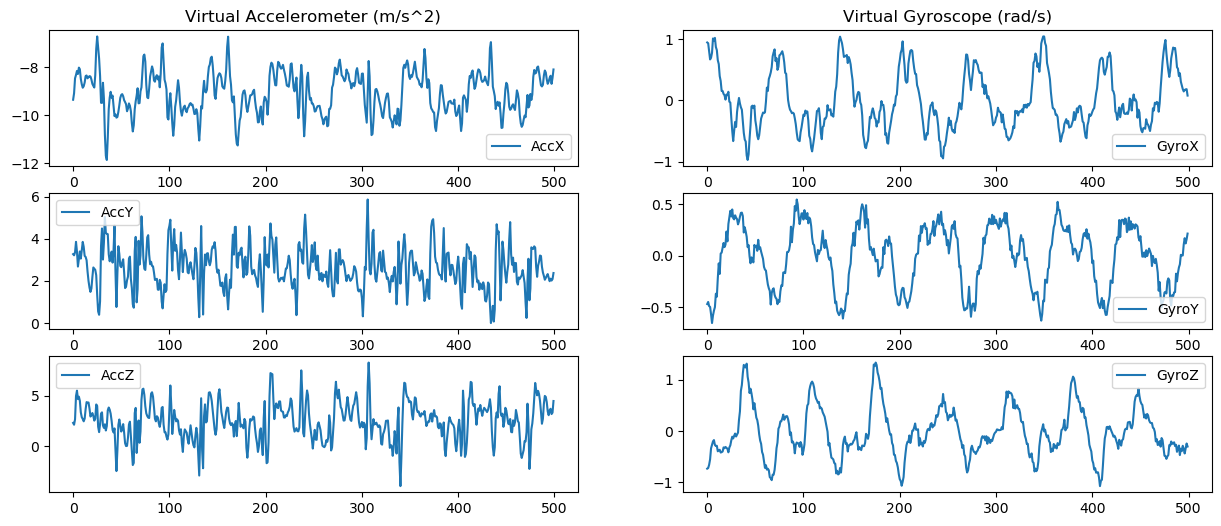

In [8]:
# Visualization
fig, axs = plt.subplots(3, 2, figsize=(15, 6))
acc_RLA_pre_opt, gyro_RLA_pre_opt = virtual_IMU_dict["RLA"]
start, end = 3000, 3500 # 10 sec (50 Hz)
axs[0, 0].set_title("Virtual Accelerometer (m/s^2)")
axs[0, 1].set_title("Virtual Gyroscope (rad/s)")
for i in range(3):
    axs[i, 0].plot(acc_RLA_pre_opt.detach().cpu().numpy()[start:end, i], label=f"Acc{['X', 'Y', 'Z'][i]}")
    axs[i, 0].legend()
    axs[i, 1].plot(gyro_RLA_pre_opt.detach().cpu().numpy()[start:end, i], label=f"Gyro{['X', 'Y', 'Z'][i]}")
    axs[i, 1].legend()

## 4. Initialize the Optimizer

Next, we set up the optimizer, which is responsible for updating the WIMUSim parameters to minimize the difference between the real and virtual IMU data.


In [9]:
opt = Optimizer(
        wimusim_env,
        # These meta info is optional (only for logging purpose)
        meta_info={
            "subject_id": subject_id,
            "scenario_type": scenario_type,
        },
    )

### 4.1 Set the target IMU data
To perform the parameter identification, we need to set the **target IMU data**, which is the real IMU data we want to match. This includes acceleration and gyroscope readings for each IMU in the REALDISP dataset.

In [10]:
target_IMU_dict = {
    imu_name: (
        torch.tensor(
            df_IMU[
                [f"{imu_name}_Acc{axis}" for axis in "XYZ"]
            ].values,
            device=wimusim_env.device,
        ),
        torch.tensor(
            df_IMU[
                [f"{imu_name}_Gyro{axis}" for axis in "XYZ"]
            ].values,
            device=wimusim_env.device,
        ),
    )
    for imu_name in wimusim_env.P.imu_names
}

opt.set_target_IMU_dict(target_IMU_dict)

### Step 4.2: **Define other optimization configurations**

To fine-tune the parameters, we need to define some optimization configurations, including learning rates, loss weights, and scheduling strategies.

In [11]:
opt.init_optimizers()
opt.scheduler_dict = {
    "Do": torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        opt.optimizer_dict["Do"], T_0=2, T_mult=2, eta_min=1e-8, verbose=False
    ),
    "B": torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        opt.optimizer_dict["B"], T_0=2, T_mult=2, eta_min=1e-6, verbose=False
    ),
    "Pp": torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        opt.optimizer_dict["Pp"], T_0=2, T_mult=2, eta_min=1e-6, verbose=False
    ),
    "Po": torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        opt.optimizer_dict["Pp"], T_0=2, T_mult=2, eta_min=1e-6, verbose=False
    ),
}

opt.rmse_weight_dict = {
        "RLA": (2.0, 3.0),
        "RUA": (1.0, 2.0),
        "BACK": (1.0, 1.0),
        "LUA": (1.0, 2.0),
        "LLA": (2.0, 3.0),
        "RC": (1.0, 1.0),
        "RT": (1.0, 1.0),
        "LT": (1.0, 1.0),
        "LC": (1.0, 1.0),
    }

opt.loss_coeff_dict["sym"] = 1e1
opt.loss_coeff_dict["rom"] = 1e1
opt.loss_coeff_dict["b_range"] = 1e2
opt.loss_coeff_dict["p_range"] = 1e3

opt.loss_coeff_dict # show other loss coefficients

{'rmse': 1,
 'rom': 10.0,
 'sym': 10.0,
 'b_range': 100.0,
 'p_range': 1000.0,
 'temp_reg': 0.01,
 'h_noise_dist': 1,
 'h_std': 1,
 'do_norm': 1}

### Step 5: **Run the Optimization**

Finally, we run the optimization process. During this process, the optimizer will iteratively update the parameters to minimize the error between the real and virtual IMU data. The following code use wandb to log the optimization process, but you can disable it by setting `log_wandb=False`.

In [12]:
wandb_project_name = "wimusim_realdisp_param_opt"
rand_int = np.random.randint(1000)

wandb_run_name = f"p{int(subject_id):03d}_all_{scenario_type}_{rand_int}"
    
_ = opt.fit(
    epochs=1024,
    early_stopping=False,
    log_wandb=True,
    wandb_project_config={
        "project_name": wandb_project_name,
        "run_name": wandb_run_name,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nobuyuki. Use `wandb login --relogin` to force relogin


100%|██████████| 1024/1024 [10:23<00:00,  1.64it/s]


B_BASE2L_HIP,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
B_BASE2L_HIP_gt_max_X,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
B_BASE2L_HIP_gt_max_Y,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
B_BASE2L_HIP_gt_max_Z,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
B_BASE2L_HIP_lt_min_X,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
B_BASE2L_HIP_lt_min_Y,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
B_BASE2L_HIP_lt_min_Z,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
B_BASE2PELVIS,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
B_BASE2PELVIS_gt_max_X,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
B_BASE2PELVIS_gt_max_Y,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
B_BASE2PELVIS_gt_max_Z,▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


## Visualization and Analysis

### 1. **Comparing Real and Virtual IMU Data**
To evaluate the effectiveness of the parameter identification process, we will visualize the real IMU data (`target_IMU`), the initial (pre-optimization) virtual IMU data, and the optimized virtual IMU data on the same plot. This comparison allows us to see how closely the virtual IMU data has aligned with the real IMU data after optimization.

The following plot compares the acc and gyro of target IMU (real data), pre-optimization virtual IMU, optimized virtual IMU for RLA IMU:

In [13]:
virtual_IMU_dict_opt = opt.env.simulate(mode="parameterise")

In [14]:
def compare_real_virtual_IMU(target_IMU_dict, virtual_IMU_dict, imu_name="RLA", start=3000, end=3500):
    fig, axs = plt.subplots(3, 2, figsize=(15, 6))
    acc_pre_opt, gyro_pre_opt = virtual_IMU_dict[imu_name]
    acc_real, gyro_real = target_IMU_dict[imu_name]
    acc_sim, gyro_sim = virtual_IMU_dict[imu_name]

    axs[0, 0].set_title("Real vs Virtual Accelerometer (m/s^2)")
    axs[0, 1].set_title("Real vs Virtual Gyroscope (rad/s)")
    for i in range(3):
        axs[i, 0].plot(acc_real.detach().cpu().numpy()[start:end, i], label=f"Acc_real_{['X', 'Y', 'Z'][i]}")
        axs[i, 0].plot(acc_sim.detach().cpu().numpy()[start:end, i], label=f"Acc_sim_{['X', 'Y', 'Z'][i]}")

        axs[i, 0].legend()
        axs[i, 1].plot(gyro_real.detach().cpu().numpy()[start:end, i], label=f"Gyro_real_{['X', 'Y', 'Z'][i]}")
        axs[i, 1].plot(gyro_sim.detach().cpu().numpy()[start:end, i], label=f"Gyro_sim{['X', 'Y', 'Z'][i]}")
        axs[i, 1].legend()
    plt.show()

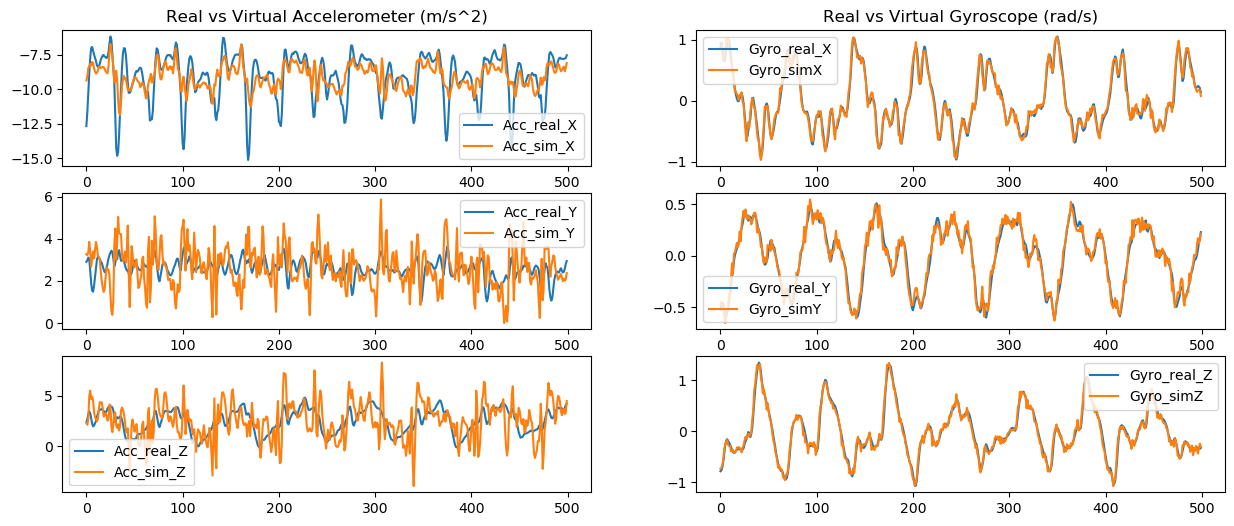

In [15]:
# Compare the real and virtual IMU (pre-opt) data for the RLA
compare_real_virtual_IMU(target_IMU_dict, virtual_IMU_dict, imu_name="RLA")

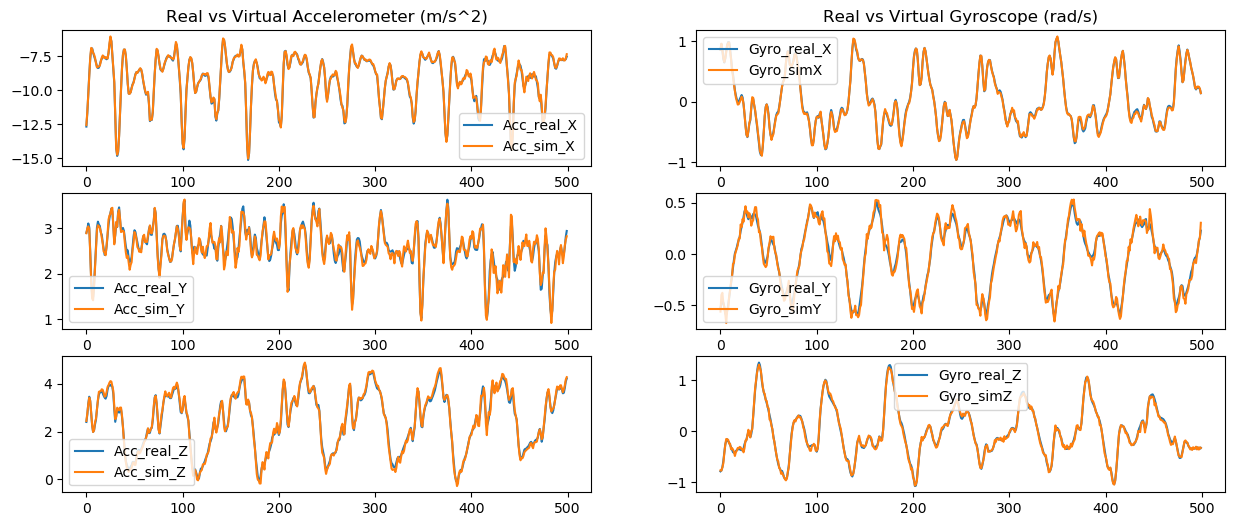

In [16]:
# Compare the real and virtual IMU (post-opt) data for the RLA
compare_real_virtual_IMU(target_IMU_dict, virtual_IMU_dict_opt, imu_name="RLA")

### 2. **3D Visualization in PyBullet**
You can also visualize the moving humanoid in the 3D PyBullet environment. This visualization will show the human body model and the IMU placements, making it easy to see the overall movement patterns.

In [17]:
wimusim_env.launch_pybullet_client()
wimusim_env.run_visualization()

startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce GTX 1080 Ti/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 515.105.01
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 515.105.01
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce GTX 1080 Ti/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


## Conclusion
By identifying the parameters, WIMUSim can generate high-fidelity virtual IMU data that closely matches real-world recordings.